# Autoregressive Abstracter: Card Sorting

## Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import sklearn.metrics
from sklearn.model_selection import train_test_split
import pydealer

import seq2seq_transformer
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder

from hand2hand import Cards
import utils

In [2]:
%env "WANDB_NOTEBOOK_NAME" "autoregressive_abstracter_hand_sorting.ipynb"

import wandb
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="autoregressive_abstracter_hand_sorting.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


True

In [3]:
def create_callbacks(monitor='loss'):
    callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

# metrics = [
#         tf.keras.metrics.BinaryAccuracy(name='acc'),
#         tf.keras.metrics.Precision(class_id=1, name='precision'),
#         tf.keras.metrics.Recall(class_id=1, name='recall'),
#         tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
#         ]

# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# opt = tf.keras.optimizers.Adam()

## Dataset

In [4]:
hand_size = 7

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()

In [5]:
n = 10000
BEGIN_HAND = 52 # token for 'beginning of hand'
END_HAND = 53 # token for 'end of hand'

hands = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)
hands_sorted = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        #print('shuffling deck')
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    source = list(deck.index_pyhand(hand))
    source.insert(0,BEGIN_HAND)
    source.append(END_HAND)
    hands[i] = np.array(source)
    deck.sort_pyhand(hand)
    target = list(deck.index_pyhand(hand))
    target.insert(0,BEGIN_HAND)
    target.append(END_HAND)
    hands_sorted[i] = np.array(target)


In [6]:
hands_train, hands_test, sorted_train, sorted_test = train_test_split(hands, hands_sorted, test_size=0.25)

source_train = hands_train
target_train = sorted_train[:,:-1]
labels_train = sorted_train[:,1:]

source_test = hands_test
target_test = sorted_test[:,:-1]
labels_test = sorted_test[:,1:]

In [7]:
def evaluate_seq2seq_model(model):
    n = len(source_test)
    output = np.zeros(n*(hand_size+2), dtype=int).reshape(n,hand_size+2)
    output[:,0] = BEGIN_HAND
    for i in range(hand_size+1):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    acc = (np.sum(output[:,1:] == labels_test))/np.prod(labels_test.shape)
    print('per-card accuracy: %.2f%%' % (100*acc))

    return acc

## Standard Transformer

In [8]:
# from seq2seq_transformer import Encoder

# inputs = layers.Input(shape=(9,), name='token_input')
# target = layers.Input(shape=(8,), name='token_target')

# token_embedder = layers.Embedding(54, 128, name='vector_embedding')
# pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
# pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')
# encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='transformer_encoder')

# decoder = Decoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='transformer_decoder')

# x = token_embedder(inputs)
# x = pos_embedding_adder_input(x)

# encoder_context = encoder(x)

# target_embedding = token_embedder(target)
# target_embedding = pos_embedding_adder_target(target_embedding)

# x = decoder(target_embedding, encoder_context)

# x = layers.Dense(54)(x)

# transformer = Model(inputs=[inputs, target], outputs=x)

In [9]:
from seq2seq_transformer import Encoder, AddPositionalEmbedding

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, cross_attention_type='std_encoder_decoder', name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, context_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [10]:
transformer = Transformer(num_layers=2, num_heads=2, dff=64, 
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [11]:
from seq2seq_transformer import masked_loss, masked_accuracy

transformer.compile(loss=masked_loss, optimizer=tf.keras.optimizers.Adam(), metrics=masked_accuracy)
transformer((source_train, target_train))

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 decoder (ContextDecoder)    multiple                  562560    
                                                       

In [12]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='std transformer')
history = transformer.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 22s 85ms/step - loss: 1.5534 - masked_accuracy: 0.5934
Epoch 2/20
118/118 [==============================] - 10s 87ms/step - loss: 0.1704 - masked_accuracy: 0.9549
Epoch 3/20
118/118 [==============================] - 10s 87ms/step - loss: 0.0874 - masked_accuracy: 0.9769
Epoch 4/20
118/118 [==============================] - 12s 106ms/step - loss: 0.0584 - masked_accuracy: 0.9843
Epoch 5/20
118/118 [==============================] - 12s 102ms/step - loss: 0.0422 - masked_accuracy: 0.9883
Epoch 6/20
118/118 [==============================] - 11s 95ms/step - loss: 0.0398 - masked_accuracy: 0.9892
Epoch 7/20
118/118 [==============================] - 11s 89ms/step - loss: 0.0393 - masked_accuracy: 0.9893
Epoch 8/20
118/118 [==============================] - 14s 121ms/step - loss: 0.0301 - masked_accuracy: 0.9919
Epoch 9/20
118/118 [==============================] - 11s 95ms/step - loss: 0.0307 - masked_accuracy: 0.9922
Epoch 10/20
118/

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▇██████████████████
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.01759
epoch/masked_accuracy,0.99527


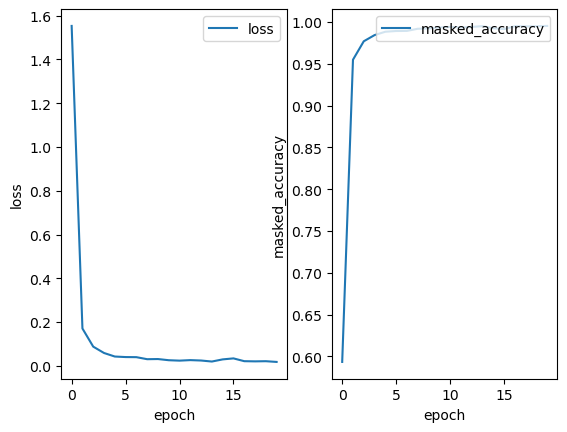

In [13]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [14]:
evaluate_seq2seq_model(transformer);

per-card accuracy: 96.30%


## Autoregressive Abstracter with 'Symbolic' Cross-Attention $(Q=A, K=E, V=A)$

In [15]:
from symbolic_decoder import SymbolicDecoder

class AutoregressiveSymbolicAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = SymbolicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, cross_attention_type='std_encoder_decoder', name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, context_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [16]:
autoregressive_symbolic_abstracter = AutoregressiveSymbolicAbstracter(num_layers=2, num_heads=2, dff=64,
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [17]:
from seq2seq_transformer import masked_loss, masked_accuracy

autoregressive_symbolic_abstracter.compile(loss=masked_loss, optimizer=tf.keras.optimizers.Adam(), metrics=masked_accuracy)
autoregressive_symbolic_abstracter((source_train, target_train))

autoregressive_symbolic_abstracter.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (SymbolicDecoder  multiple                 563712    
 )                                                     

In [18]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive symbolic abstracter')
history = autoregressive_symbolic_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 35s 139ms/step - loss: 2.6926 - masked_accuracy: 0.2083
Epoch 2/20
118/118 [==============================] - 16s 138ms/step - loss: 2.3684 - masked_accuracy: 0.2429
Epoch 3/20
118/118 [==============================] - 18s 149ms/step - loss: 2.1632 - masked_accuracy: 0.2968
Epoch 4/20
118/118 [==============================] - 18s 154ms/step - loss: 2.0103 - masked_accuracy: 0.3442
Epoch 5/20
118/118 [==============================] - 17s 145ms/step - loss: 1.8344 - masked_accuracy: 0.3920
Epoch 6/20
118/118 [==============================] - 18s 155ms/step - loss: 1.6837 - masked_accuracy: 0.4326
Epoch 7/20
118/118 [==============================] - 18s 154ms/step - loss: 1.5568 - masked_accuracy: 0.4646
Epoch 8/20
118/118 [==============================] - 21s 175ms/step - loss: 1.4527 - masked_accuracy: 0.4985
Epoch 9/20
118/118 [==============================] - 16s 133ms/step - loss: 1.3646 - masked_accuracy: 0.5306
Epoch 10/2

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
epoch/masked_accuracy,▁▁▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇███
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.51483
epoch/masked_accuracy,0.81755


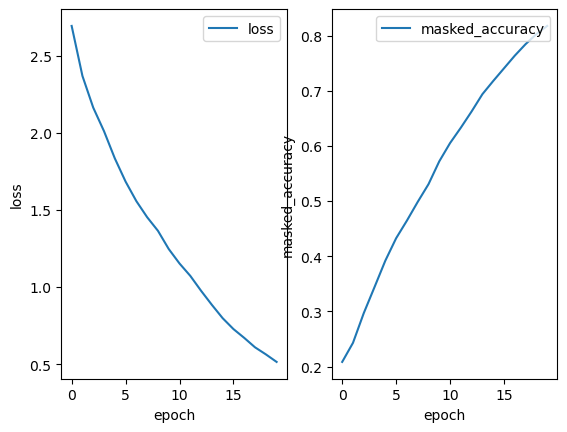

In [19]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [20]:
evaluate_seq2seq_model(autoregressive_symbolic_abstracter);

per-card accuracy: 76.59%


## Autoregressive Abstracter with 'Episodic' Cross-Attention $(Q=E, K=E, V=E)$

In [21]:
from seq2seq_transformer import EpisodicDecoder

class AutoregressiveEpisodicAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='autoregressive_episodic_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, cross_attention_type='std_encoder_decoder', name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, context_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [22]:
autoregressive_episodic_abstracter = AutoregressiveEpisodicAbstracter(num_layers=2, num_heads=2, dff=64, 
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [23]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=128)
autoregressive_episodic_abstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
autoregressive_episodic_abstracter((source_train, target_train))

autoregressive_episodic_abstracter.summary()

Model: "autoregressive_episodic_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (EpisodicDecoder  multiple                 563712    
 )                              

In [24]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive relational abstracter')
history = autoregressive_episodic_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 30s 123ms/step - loss: 4.2365 - masked_accuracy: 0.0649
Epoch 2/20
118/118 [==============================] - 14s 120ms/step - loss: 3.3784 - masked_accuracy: 0.1589
Epoch 3/20
118/118 [==============================] - 14s 118ms/step - loss: 2.8358 - masked_accuracy: 0.1945
Epoch 4/20
118/118 [==============================] - 14s 116ms/step - loss: 2.5641 - masked_accuracy: 0.2267
Epoch 5/20
118/118 [==============================] - 14s 117ms/step - loss: 2.3604 - masked_accuracy: 0.2637
Epoch 6/20
118/118 [==============================] - 14s 118ms/step - loss: 2.0540 - masked_accuracy: 0.3457
Epoch 7/20
118/118 [==============================] - 14s 122ms/step - loss: 1.5329 - masked_accuracy: 0.5166
Epoch 8/20
118/118 [==============================] - 20s 173ms/step - loss: 0.9936 - masked_accuracy: 0.7065
Epoch 9/20
118/118 [==============================] - 22s 187ms/step - loss: 0.6138 - masked_accuracy: 0.8276
Epoch 10/2

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▂▂▂▃▃▅▆▇▇██████████
epoch/epoch,19
epoch/learning_rate,0.00082
epoch/loss,0.15107
epoch/masked_accuracy,0.95706


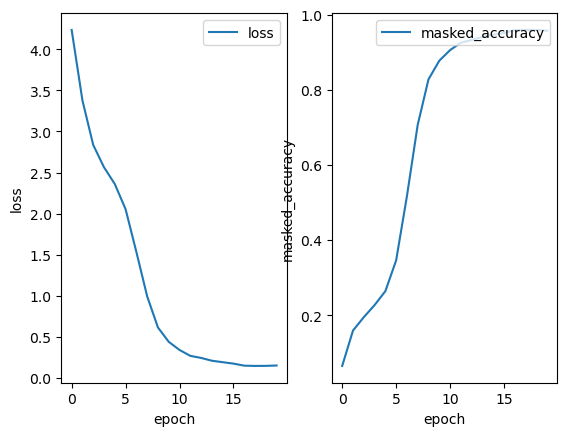

In [25]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [26]:
evaluate_seq2seq_model(autoregressive_episodic_abstracter);

per-card accuracy: 95.06%


## Multi-Abstracter Model

$$\text{Encoder} \to \text{Abstracter} \to \cdots \to \text{Abstracter} \to \text{Decoder}$$

In [27]:
from seq2seq_transformer import EpisodicDecoder

class AutoregressiveEpisodicMultiAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim, n_abstracters=2,
            dropout_rate=0.1, name='autoregressive_episodic_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracters = [
            EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
            for _ in range(n_abstracters)]
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, cross_attention_type='std_encoder_decoder', name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = encoder_context
        for abstracter in self.abstracters:
            abstracted_context = abstracter(abstracted_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, context_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [28]:
autoregressive_episodic_multiabstracter = AutoregressiveEpisodicMultiAbstracter(num_layers=2, num_heads=2, dff=64,
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128, n_abstracters=2)

In [29]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=128)
autoregressive_episodic_multiabstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
autoregressive_episodic_multiabstracter((source_train, target_train))

autoregressive_episodic_multiabstracter.summary()

Model: "autoregressive_episodic_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (EpisodicDecoder  multiple                 563712    
 )                              

In [30]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive relational multi-abstracter')
history = autoregressive_episodic_multiabstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 45s 203ms/step - loss: 4.1189 - masked_accuracy: 0.0915
Epoch 2/20
118/118 [==============================] - 27s 226ms/step - loss: 3.3674 - masked_accuracy: 0.1601
Epoch 3/20
118/118 [==============================] - 25s 210ms/step - loss: 2.8515 - masked_accuracy: 0.1973
Epoch 4/20
118/118 [==============================] - 22s 190ms/step - loss: 2.5933 - masked_accuracy: 0.2175
Epoch 5/20
118/118 [==============================] - 25s 209ms/step - loss: 2.4931 - masked_accuracy: 0.2243
Epoch 6/20
118/118 [==============================] - 20s 173ms/step - loss: 2.4464 - masked_accuracy: 0.2291
Epoch 7/20
118/118 [==============================] - 21s 178ms/step - loss: 2.4211 - masked_accuracy: 0.2304
Epoch 8/20
118/118 [==============================] - 24s 204ms/step - loss: 2.4062 - masked_accuracy: 0.2300
Epoch 9/20
118/118 [==============================] - 23s 195ms/step - loss: 2.3939 - masked_accuracy: 0.2328
Epoch 10/2

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▄▆▇▇███████████████
epoch/epoch,19
epoch/learning_rate,0.00082
epoch/loss,2.3602
epoch/masked_accuracy,0.23655


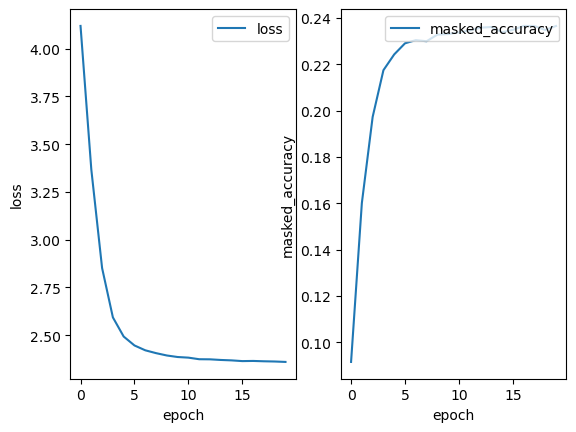

In [31]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [32]:
evaluate_seq2seq_model(autoregressive_episodic_multiabstracter);

per-card accuracy: 15.61%
